# Exploring the NHDPlus Seamless CONUS gdb
## Making tools to access individual features quickly

In [1]:
import fiona
import json

### Set the gdb path and the layer name
gdb source: http://www.horizon-systems.com/NHDPlus/V2NationalData.php

download link: http://www.horizon-systems.com/NHDPlusData/NHDPlusV21/Data/NationalData/NHDPlusV21_NationalData_Seamless_Geodatabase_Lower48_07.7z

documentation: http://www.horizon-systems.com/NHDPlusData/NHDPlusV21/Data/NationalData/0Release_Notes_NationalData_Seamless_GeoDatabase.pdf

In [23]:
gdb = r'data\NHDPlusV21\NHDPlusV21_National_Seamless_Flattened_Lower48.gdb'
lyr = 'NHDFlowline_Network'

### Open the gdb, layer

In [24]:
src = fiona.open(gdb, layer=lyr)

### Make a dict that allow for easy/fast indexing of our layer of interest

In [4]:
# comidDict = {src[f]['properties']['COMID']: f for f in src.keys()}

### Write it to a json

In [5]:
# with open('data/comidDict_NHDPlusV21.json', 'w') as fp:
#     json.dump(comidDict, fp, indent=2)

# END

---

#### dev work below

In [31]:
with open('data/NHDPlusV21/comidDict_NHDPlusV21.json') as f:
    comidDict = json.loads(f.read())

In [27]:
node_lyr = 'PlusFlow'
node_src = fiona.open(gdb, layer=node_lyr)

In [28]:
comid = 4512772 # some small segment on the Potomac near DC

In [29]:
# import importlib
# import fcast
# importlib.reload(fcast)
import sys; sys.path.append('..')
from fcast import StreamSegmentNHD

In [69]:
import geopandas as gpd
from shapely.geometry import Point

In [32]:
test = StreamSegmentNHD(comid, comidDict, src, warning=False)

In [33]:
test.from_node_id

200011819.0

In [34]:
test.to_node_id

200011746.0

In [74]:
node_src.meta['schema']['properties']

OrderedDict([('FROMCOMID', 'int'),
             ('FROMHYDSEQ', 'float'),
             ('FROMLVLPAT', 'float'),
             ('TOCOMID', 'int'),
             ('TOHYDSEQ', 'float'),
             ('TOLVLPAT', 'float'),
             ('NODENUMBER', 'float'),
             ('DELTALEVEL', 'int'),
             ('DIRECTION', 'int'),
             ('GAPDISTKM', 'float'),
             ('HasGeo', 'str:1'),
             ('TotDASqKM', 'float'),
             ('DivDASqKM', 'float')])

## Make a dict to easily access the PlusFlow layer

In [36]:
node_id_dict = {node_src[f]['properties']['NODENUMBER']: f for f in node_src.keys()}

## Pull the to/from comid based on matching node numbers

In [45]:
x = node_src[node_id_dict[test.from_node_id]]['properties']
assert x['TOCOMID'] == comid, "For some reason this Node Number is wrong"
fromcomid = x['FROMCOMID']

In [48]:
fromcseg = StreamSegmentNHD(fromcomid, comidDict, src, warning=False)

## Determine which end point is upstream and which is downstream

In [70]:
endpt1 = Point(list(list(fromcseg.geometry)[0].coords)[0])
endpt2 = Point(list(list(fromcseg.geometry)[0].coords)[-1])

In [75]:
endpt1.distance(test.geometry) # downstream

0.005169302509850152

In [76]:
endpt2.distance(test.geometry) # upstream

0.0

# Using the above, the upstream and downstream point can be determined, as well as the upstream and downstream comids

### Plot to visibly make sure they are next to each other

In [58]:
gdf = gpd.GeoDataFrame({comid: test.geometry, fromcomid: fromcseg.geometry}).T.reset_index().rename(columns={'index':'comid', 0:'geometry'}).set_geometry('geometry')
gdf

,comid,geometry
0,4512772,LINESTRING Z (-77.13370492404636 38.9543206062...
1,4512770,LINESTRING Z (-77.13741032404067 38.9579250061...


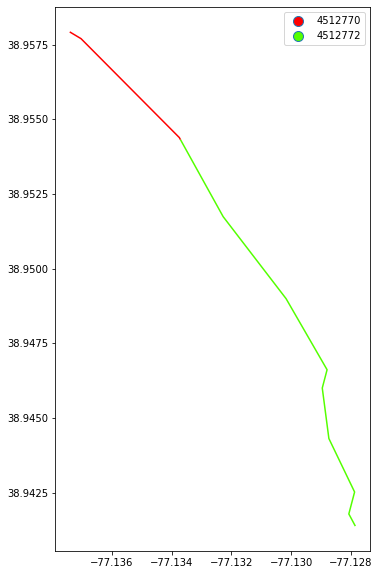

In [60]:
gdf.plot(figsize=(10,10), categorical=True, column='comid', legend=True, cmap='prism')